# Importing Essential Libraries for Preprocessing

In [1]:
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt

from pymatgen.core import Composition
from matminer.featurizers.composition.alloy import WenAlloys

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split,cross_val_score
from skopt.space import Real, Integer, Categorical
from skopt.utils import use_named_args
from skopt.plots import plot_objective, plot_convergence
from skopt import gp_minimize

# Extracting imputed database

In [2]:
db = pd.read_csv('FeNiCo_comp-prop_imp.csv')
db = db.iloc[:,1:]
db

,Fe,Co,Ni,V,Mo,Cr,Cu,Mn,C,W,...,Si,Ms,Hc,Tc,ER,TS,YS,Elong,HV,Cost
0,100.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,2.23,39.40,724.00,8.56,NaN,NaN,40.00,104.96,0.42
1,99.00,1.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,2.24,72.22,739.00,11.90,NaN,NaN,40.00,104.25,0.77
2,98.00,2.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,2.25,97.21,753.00,14.13,NaN,NaN,40.00,103.76,1.11
3,97.00,3.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,2.26,119.77,767.00,15.94,NaN,NaN,40.00,103.52,1.45
4,96.00,4.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,2.27,147.59,780.00,17.64,NaN,NaN,40.00,103.50,1.79
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1203,49.25,49.25,0.0,1.5,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,2.24,966.00,964.41,29.86,NaN,NaN,7.35,265.30,21.77
1204,49.25,49.25,0.0,1.5,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,2.21,1066.00,964.41,29.86,NaN,NaN,7.35,265.30,21.77
1205,49.25,49.25,0.0,1.5,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,2.30,383.00,964.41,29.86,NaN,NaN,7.35,265.30,21.77
1206,49.25,49.25,0.0,1.5,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,2.28,351.00,964.41,29.86,NaN,NaN,7.35,265.30,21.77


In [3]:
db.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1208 entries, 0 to 1207
Data columns (total 24 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Fe      1208 non-null   float64
 1   Co      1208 non-null   float64
 2   Ni      1208 non-null   float64
 3   V       1208 non-null   float64
 4   Mo      1208 non-null   float64
 5   Cr      1208 non-null   float64
 6   Cu      1208 non-null   float64
 7   Mn      1208 non-null   float64
 8   C       1208 non-null   float64
 9   W       1208 non-null   float64
 10  Ta      1208 non-null   float64
 11  Nb      1208 non-null   float64
 12  Al      1208 non-null   float64
 13  Ti      1208 non-null   float64
 14  Si      1208 non-null   float64
 15  Ms      1208 non-null   float64
 16  Hc      1208 non-null   float64
 17  Tc      1208 non-null   float64
 18  ER      1208 non-null   float64
 19  TS      244 non-null    float64
 20  YS      239 non-null    float64
 21  Elong   1208 non-null   float64
 22  

In [4]:
db = pd.concat([db.iloc[:,:19],db.iloc[:,21:]], axis=1)
db.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1208 entries, 0 to 1207
Data columns (total 22 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Fe      1208 non-null   float64
 1   Co      1208 non-null   float64
 2   Ni      1208 non-null   float64
 3   V       1208 non-null   float64
 4   Mo      1208 non-null   float64
 5   Cr      1208 non-null   float64
 6   Cu      1208 non-null   float64
 7   Mn      1208 non-null   float64
 8   C       1208 non-null   float64
 9   W       1208 non-null   float64
 10  Ta      1208 non-null   float64
 11  Nb      1208 non-null   float64
 12  Al      1208 non-null   float64
 13  Ti      1208 non-null   float64
 14  Si      1208 non-null   float64
 15  Ms      1208 non-null   float64
 16  Hc      1208 non-null   float64
 17  Tc      1208 non-null   float64
 18  ER      1208 non-null   float64
 19  Elong   1208 non-null   float64
 20  HV      1208 non-null   float64
 21  Cost    1208 non-null   float64
dtype

# Adding WenAlloys features

In [5]:
elem = db.columns[:15].tolist()
form_list = []
for i in range(db.shape[0]):
    formula = ''
    for j in elem:
        if not db[j][i]==0:
            formula+=j
            formula+=str(db[j][i])
    form_list.append(formula)

In [6]:
db['pretty_formula']=form_list
db

,Fe,Co,Ni,V,Mo,Cr,Cu,Mn,C,W,...,Ti,Si,Ms,Hc,Tc,ER,Elong,HV,Cost,pretty_formula
0,100.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,2.23,39.40,724.00,8.56,40.00,104.96,0.42,Fe100.0
1,99.00,1.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,2.24,72.22,739.00,11.90,40.00,104.25,0.77,Fe99.0Co1.0
2,98.00,2.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,2.25,97.21,753.00,14.13,40.00,103.76,1.11,Fe98.0Co2.0
3,97.00,3.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,2.26,119.77,767.00,15.94,40.00,103.52,1.45,Fe97.0Co3.0
4,96.00,4.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,2.27,147.59,780.00,17.64,40.00,103.50,1.79,Fe96.0Co4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1203,49.25,49.25,0.0,1.5,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,2.24,966.00,964.41,29.86,7.35,265.30,21.77,Fe49.25Co49.25V1.5
1204,49.25,49.25,0.0,1.5,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,2.21,1066.00,964.41,29.86,7.35,265.30,21.77,Fe49.25Co49.25V1.5
1205,49.25,49.25,0.0,1.5,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,2.30,383.00,964.41,29.86,7.35,265.30,21.77,Fe49.25Co49.25V1.5
1206,49.25,49.25,0.0,1.5,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,2.28,351.00,964.41,29.86,7.35,265.30,21.77,Fe49.25Co49.25V1.5


In [7]:
# function to get the Wen alloys features for every composition
def get_alloy_features(form_list):
    wen_alloys = WenAlloys()
    feat_list = []
    for i in form_list:
        wen_alloys = WenAlloys()
        comp = Composition(i)
        all_features = wen_alloys.featurize(comp)
        feat_list.append(np.array(all_features[2:]))
    return np.stack(feat_list,axis=0)

In [8]:
a = get_alloy_features(form_list)
a.shape

(1208, 23)

#### Extracting input columns and all the desired properties

In [9]:
X = np.array(db.iloc[:,:-8])
X.shape

(1208, 15)

In [10]:
X_all = np.concatenate([X,a],axis=1)
X_all.shape

(1208, 38)

In [11]:
y = pd.concat([db.iloc[:,-8],np.log10(db.iloc[:,-7]),np.log10(db.iloc[:,-6]+273),np.log10(db.iloc[:,-5:-1])],axis=1)
y.rename(columns = {'Hc' : 'logHc', 'ER' : 'logER', 'Tc':'logTc', 'Elong':'logEl', 'HV':'logHV', 'Cost':'logCost'}, inplace = True)
y.head()

,Ms,logHc,logTc,logER,logEl,logHV,logCost
0,2.23,1.595496,2.998695,0.932474,1.60206,2.021024,-0.376751
1,2.24,1.858657,3.005181,1.075547,1.60206,2.018076,-0.113509
2,2.25,1.987711,3.011147,1.150142,1.60206,2.016030,0.045323
3,2.26,2.078348,3.017033,1.202488,1.60206,2.015024,0.161368
4,2.27,2.169057,3.022428,1.246499,1.60206,2.014940,0.252853


In [12]:
scalerX = StandardScaler()
X_transform = scalerX.fit_transform(X_all)
scalerY = StandardScaler()
y_transform = scalerY.fit_transform(y)

In [13]:
features_db = db.iloc[:,:15].columns.values
features_db

array(['Fe', 'Co', 'Ni', 'V', 'Mo', 'Cr', 'Cu', 'Mn', 'C', 'W', 'Ta',
       'Nb', 'Al', 'Ti', 'Si'], dtype=object)

In [14]:
wen_alloys = WenAlloys()
wen_features = wen_alloys.feature_labels()
wenfeatures = np.array(wen_features[2:])
wenfeatures

array(['Yang delta', 'Yang omega', 'APE mean', 'Radii local mismatch',
       'Radii gamma', 'Configuration entropy', 'Atomic weight mean',
       'Total weight', 'Lambda entropy', 'Electronegativity delta',
       'Electronegativity local mismatch', 'VEC mean', 'Mixing enthalpy',
       'Mean cohesive energy', 'Interant electrons',
       'Interant s electrons', 'Interant p electrons',
       'Interant d electrons', 'Interant f electrons',
       'Shear modulus mean', 'Shear modulus delta',
       'Shear modulus local mismatch', 'Shear modulus strength model'],
      dtype='<U32')

In [15]:
features = np.concatenate([features_db,wenfeatures],axis=0)
features

array(['Fe', 'Co', 'Ni', 'V', 'Mo', 'Cr', 'Cu', 'Mn', 'C', 'W', 'Ta',
       'Nb', 'Al', 'Ti', 'Si', 'Yang delta', 'Yang omega', 'APE mean',
       'Radii local mismatch', 'Radii gamma', 'Configuration entropy',
       'Atomic weight mean', 'Total weight', 'Lambda entropy',
       'Electronegativity delta', 'Electronegativity local mismatch',
       'VEC mean', 'Mixing enthalpy', 'Mean cohesive energy',
       'Interant electrons', 'Interant s electrons',
       'Interant p electrons', 'Interant d electrons',
       'Interant f electrons', 'Shear modulus mean',
       'Shear modulus delta', 'Shear modulus local mismatch',
       'Shear modulus strength model'], dtype=object)

In [16]:
response = y.columns.values
response

array(['Ms', 'logHc', 'logTc', 'logER', 'logEl', 'logHV', 'logCost'],
      dtype=object)

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X_transform, y_transform, test_size=0.2, random_state=0)

# Defining functions to calculate CV metric scores

In [18]:
from sklearn import metrics

# Function to return the mean of the metric for a particular metric name
def metrics_mean(y_ac, y_pred, metric):
    score = {'Ms':[],'logHc':[],'logTc':[],'logER':[], 'logEl':[],'logHV':[], 'logCost':[]}
    n = ['Ms','logHc','logTc','logER','logEl', 'logHV', 'logCost']
    if metric == 'rmse':
        for i in range(len(n)):
            score[n[i]].append(np.sqrt(metrics.mean_squared_error(y_ac[:,i], y_pred[:,i])))
    elif metric == 'mae':
        for i in range(len(n)):
            score[n[i]].append(metrics.mean_absolute_error(y_ac[:,i], y_pred[:,i]))
    elif metric == 'R2':
        for i in range(len(n)):
            score[n[i]].append(metrics.r2_score(y_ac[:,i], y_pred[:,i]))
    else:
        for i in range(len(n)):
            score[n[i]] = np.inf
    return score

# Final function "plot" to plot the train-train predicted values, test-test predicted values and the metrics for
# each ML algorithm used
def plot(regressor_name, y_train, y_train_pred, y_test, y_test_pred):
    
    y_train = scalerY.inverse_transform(y_train)
    y_pred_train = scalerY.inverse_transform(y_train_pred)
    y_test = scalerY.inverse_transform(y_test)
    y_pred_test = scalerY.inverse_transform(y_test_pred)

    n = ['Ms','logHc','logTc','logER','logEl', 'logHV', 'logCost']
    xtl = [r'$M_s$', r'$log_{10}H_c$', r'$log_{10}T_c$', r'$log_{10}\rho$', r'$log_{10}\delta$', r'$log_{10}H_V$', r'$log_{10}Cost$']
    f, axes = plt.subplots(len(n), 2, figsize=(12,35))
    
    # training set
    for i in range(len(n)):
        # plot "predicted values vs actual values and true predictions" graph for train set using first prediction
        axes[i,0].scatter(y_train[:,i],y_pred_train[:,i])
        axes[i,0].plot(y_train[:,i],y_train[:,i],'k--',lw=3)

        axes[i,0].set_xlabel('Experimental Value',fontsize=16)
        axes[i,0].set_ylabel('Predicted Value',fontsize=16)

        # calculate the metrics
        rmse = metrics_mean(y_train,y_pred_train,'rmse')  
        mae = metrics_mean(y_train,y_pred_train,'mae')
        R2 = metrics_mean(y_train,y_pred_train,'R2')
        
        # regressor name with all metrics in the title
        axes[i,0].set_title(regressor_name+' training set'
        +'\nRMSE for '+xtl[i]+': '+str(round(rmse[n[i]][0],3))
        +'\nMAE for '+xtl[i]+': '+str(round(mae[n[i]][0],3))
        +'\nR2 for '+xtl[i]+': '+str(round(R2[n[i]][0],3)),fontsize=16, pad=10)
    
    # test set
    for i in range(len(n)):
        # plot "predicted values vs actual values and true predictions" graph for train set using first prediction
        axes[i,1].scatter(y_test[:,i],y_pred_test[:,i])
        axes[i,1].plot(y_test[:,i],y_test[:,i],'k--',lw=3)
        
        axes[i,1].set_xlabel('Experimental Value',fontsize=16)
        axes[i,1].set_ylabel('Predicted Value',fontsize=16)
        
        # calculate the metrics
        rmse = metrics_mean(y_test,y_pred_test,'rmse')  
        mae = metrics_mean(y_test,y_pred_test,'mae')
        R2 = metrics_mean(y_test,y_pred_test,'R2')
        
        # regressor name with all metrics in the title
        axes[i,1].set_title(regressor_name+' training set'
        +'\nRMSE for '+xtl[i]+': '+str(round(rmse[n[i]][0],3))
        +'\nMAE for '+xtl[i]+': '+str(round(mae[n[i]][0],3))
        +'\nR2 for '+xtl[i]+': '+str(round(R2[n[i]][0],3)),fontsize=16, pad=10)
    
    plt.tight_layout()
    plt.show()

    # return metrics for test set to record the errors across different algorithms
    return rmse, mae, R2

Empty metrics dictionaries to store the metrics for every ML algorithm

In [142]:
rmse_scores = {}
mae_scores = {}
R2_scores = {}

# Building Random Forest, Extra Trees and Deep Neural Network Regressors

In [20]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import ExtraTreesRegressor

##### Using the same hyperparameters identified for database without Wen alloy features

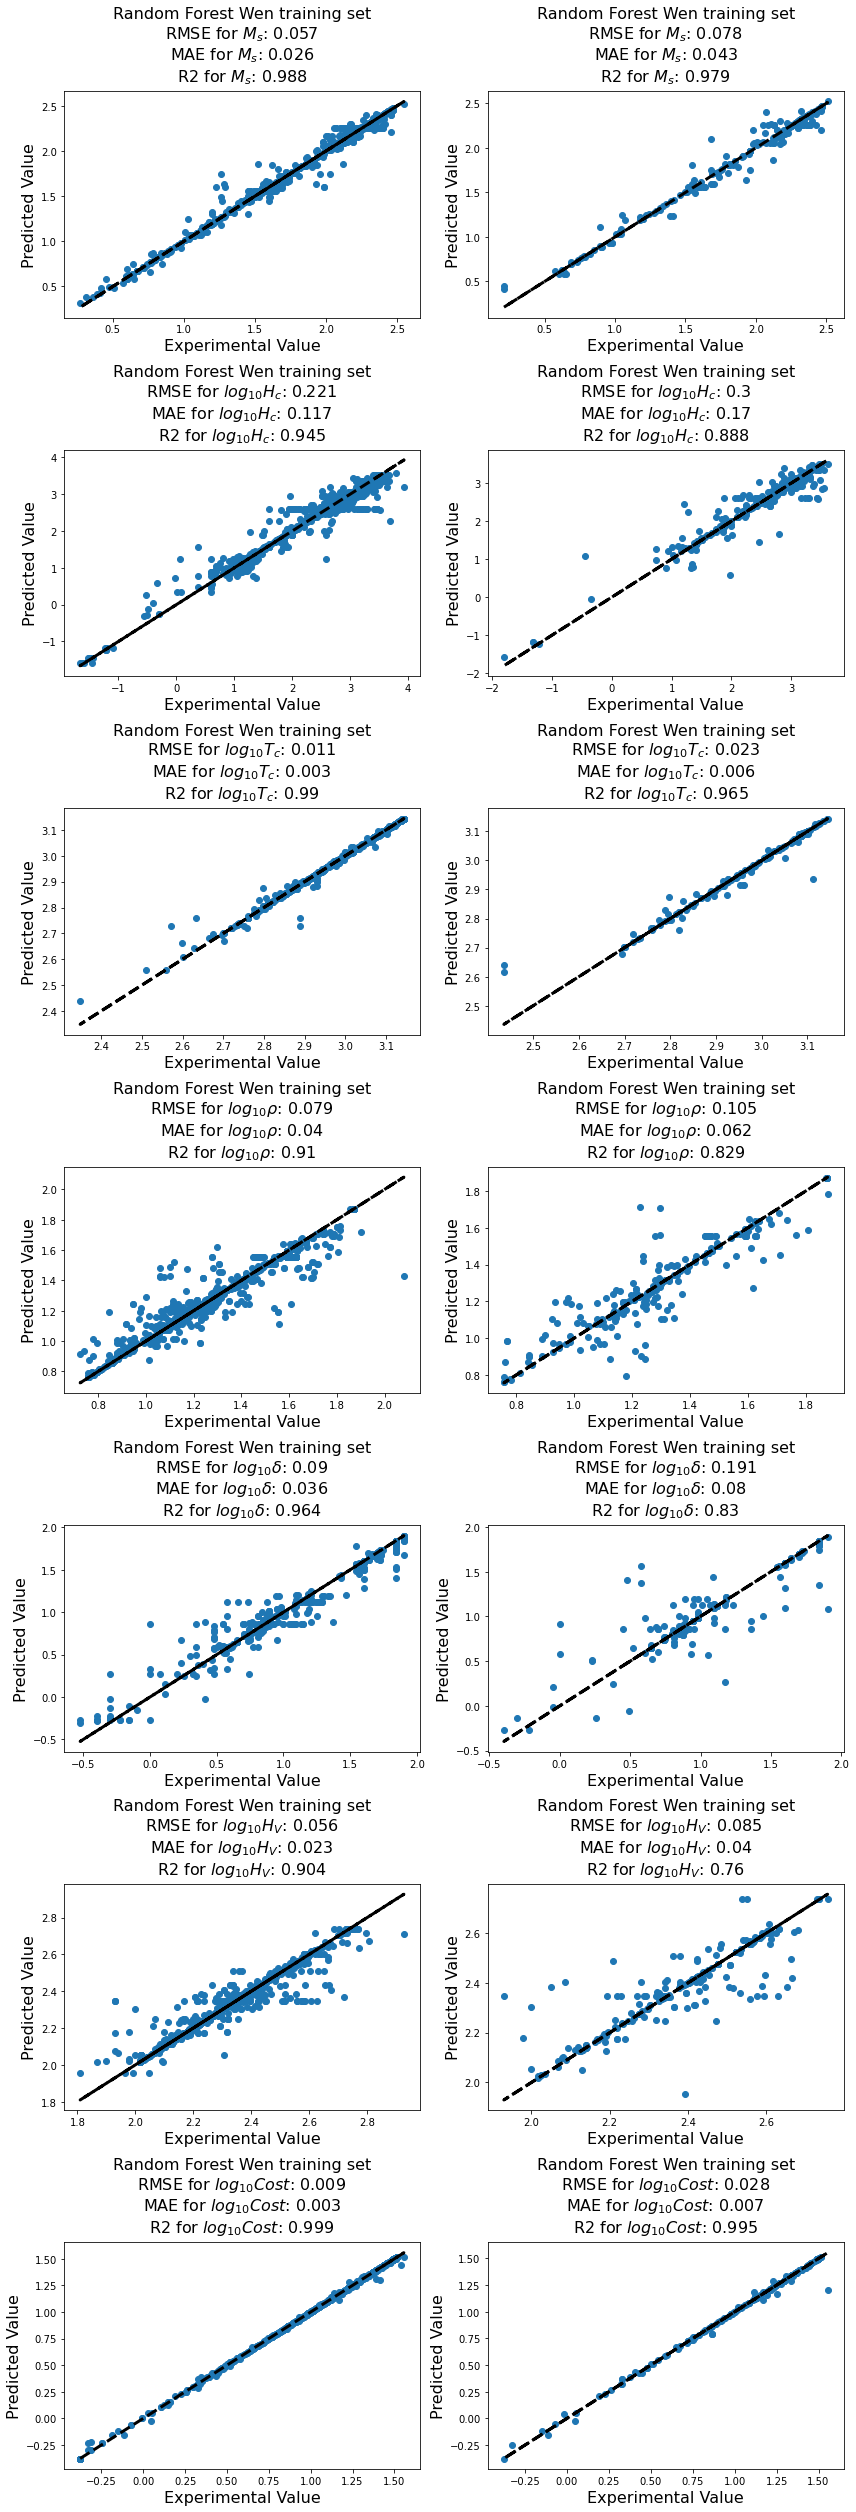

In [150]:
opt_par = [139, 72, 2, 1]

# use hyper-parameters from optimization 
n_estimators = opt_par[0]
max_depth = opt_par[1]
min_samples_split = opt_par[2]
min_samples_leaf = opt_par[3]

# Random Forest Regression
rfregressor = RandomForestRegressor(n_estimators=n_estimators, max_depth=max_depth, min_samples_split=min_samples_split,
min_samples_leaf=min_samples_leaf, random_state=0)

rfregressor.fit(X_train,y_train)
y_pred_train = rfregressor.predict(X_train)
y_pred_test = rfregressor.predict(X_test)

rmse, mae, R2 = plot('Random Forest Wen', y_train, y_pred_train, y_test, y_pred_test)

rmse_scores['Random Forest Wen'] = rmse
mae_scores['Random Forest Wen'] = mae
R2_scores['Random Forest Wen'] = R2

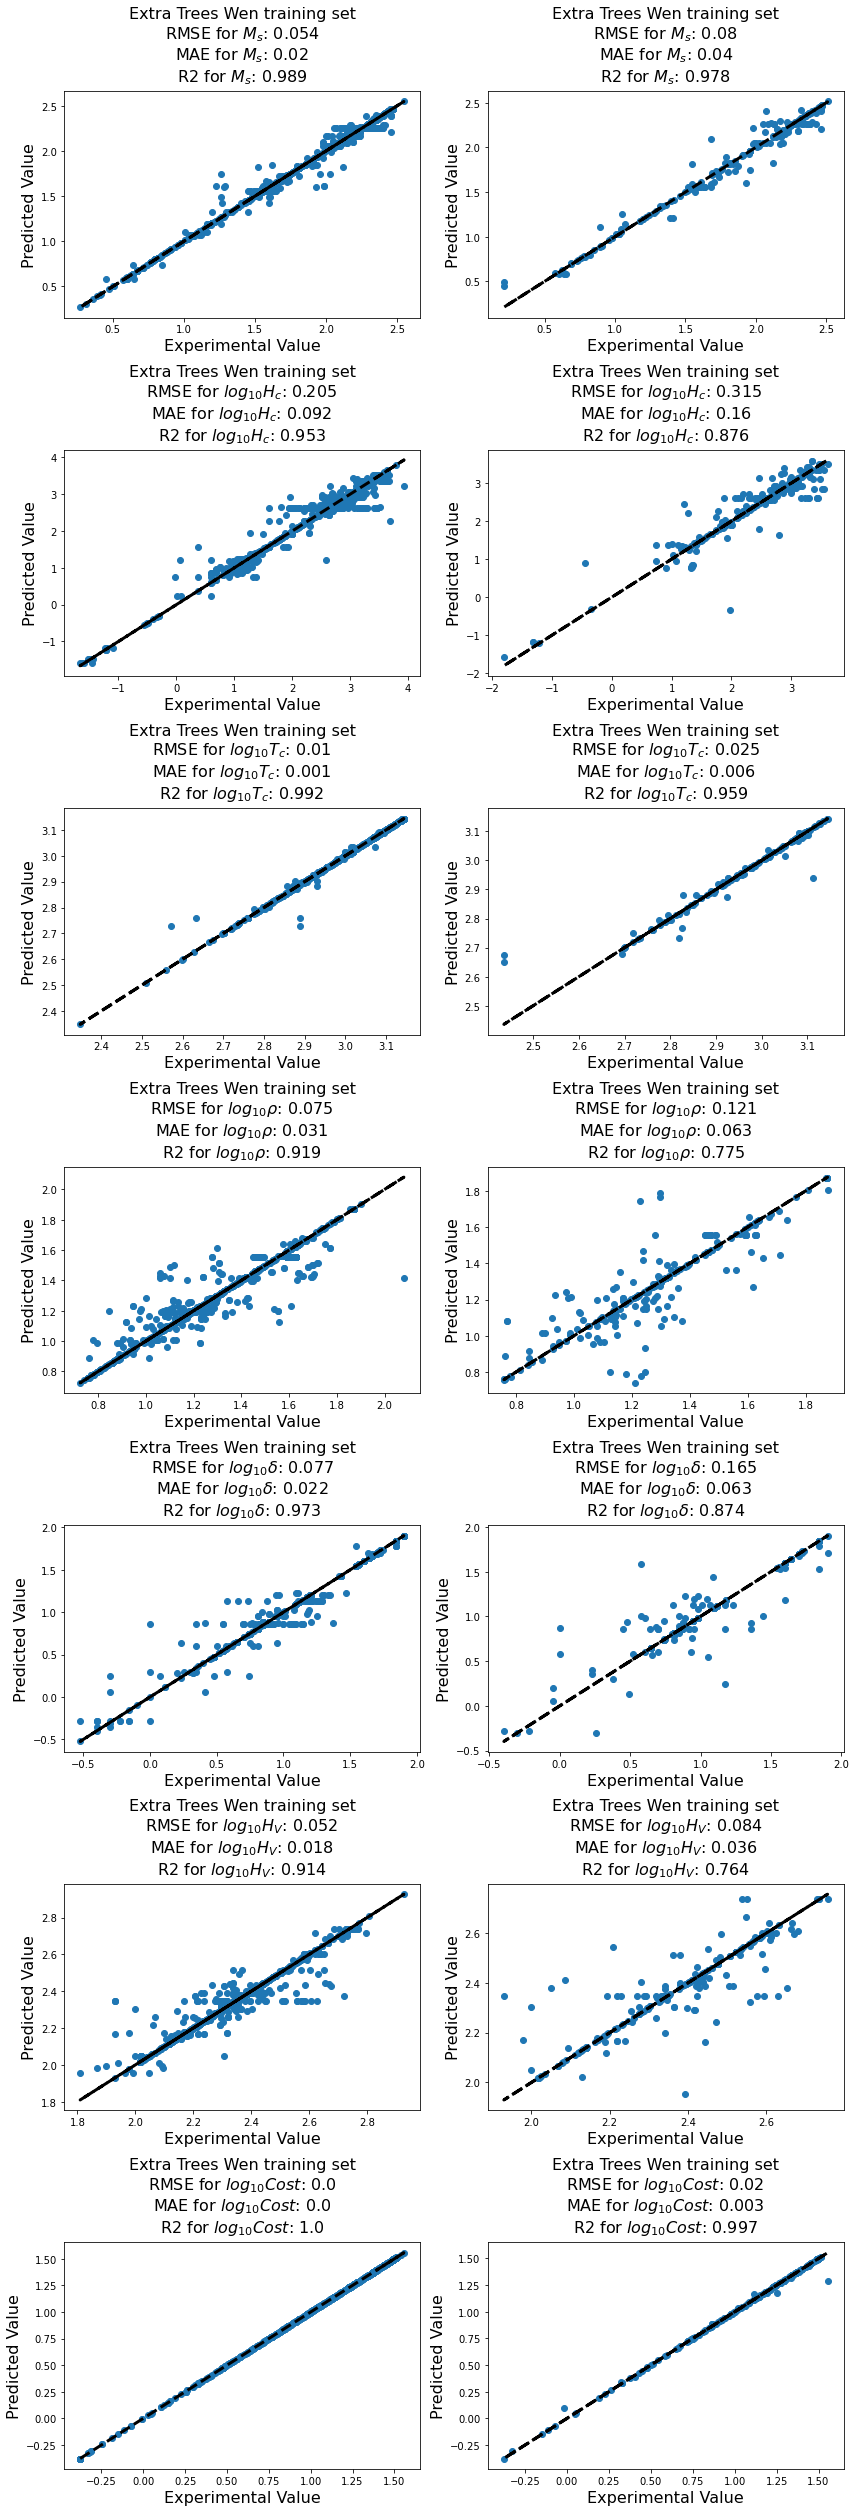

In [151]:
opt_par = [230, 81, 2, 1]

# use hyper-parameters from optimization 
n_estimators = opt_par[0]
max_depth = opt_par[1]
min_samples_split = opt_par[2]
min_samples_leaf = opt_par[3]

# Extra Trees Regression
etregressor = ExtraTreesRegressor(n_estimators=n_estimators, max_depth=max_depth, min_samples_split=min_samples_split,
min_samples_leaf=min_samples_leaf, random_state=0)

etregressor.fit(X_train,y_train)
y_pred_train = etregressor.predict(X_train)
y_pred_test = etregressor.predict(X_test)

rmse, mae, R2 = plot('Extra Trees Wen', y_train, y_pred_train, y_test, y_pred_test)

rmse_scores['Extra Trees Wen'] = rmse
mae_scores['Extra Trees Wen'] = mae
R2_scores['Extra Trees Wen'] = R2

### Feature Importance

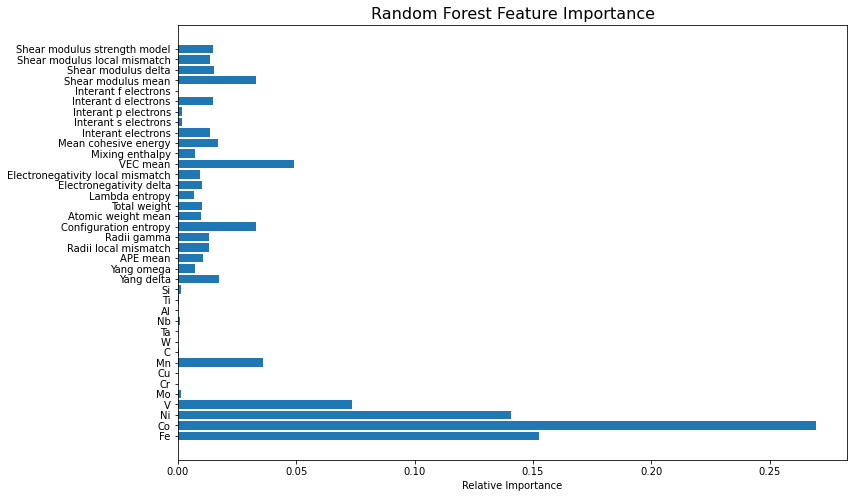

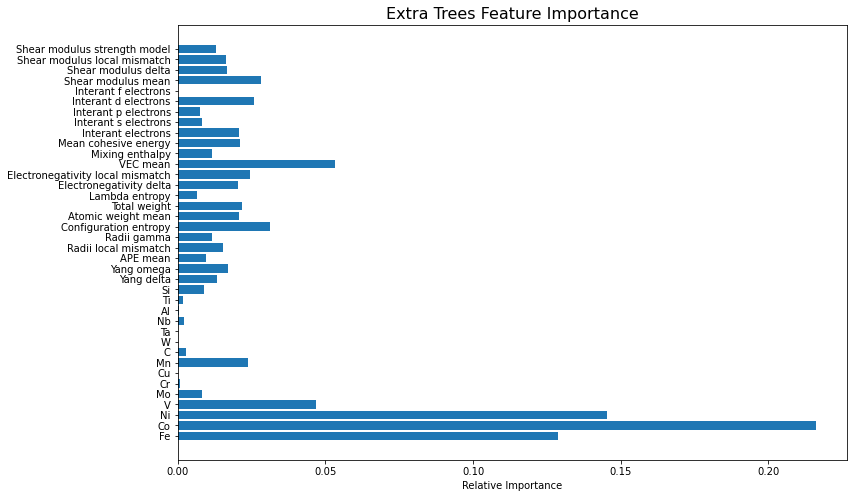

In [26]:
# defining feature importance function
def feature_importance(regr, features, title):
    
    # getting the feature importance
    feature_importance = regr.feature_importances_
    # make importances relative to max importance
    feature_importance_n = 100.0 * (feature_importance / feature_importance.max())
    plt.figure(figsize=(12, 8))
    plt.barh(range(len(feature_importance)), feature_importance, tick_label=features)

    plt.xticks(fontsize=10)
    plt.xlabel('Relative Importance')

    plt.title(title, fontsize=16)
    plt.show()

feature_importance(rfregressor, features, 'Random Forest Feature Importance')

feature_importance(etregressor, features, 'Extra Trees Feature Importance')

plt.show()

### Neural Network Regressors

In [27]:
# Importing libraries for Neural Network Regression
import tensorflow as tf
from tensorflow.python.client import device_lib
from tensorflow.keras import backend as K
from tensorflow import keras
import keras_tuner as kt
from keras import Sequential
from keras.layers import Input, InputLayer, Dense, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau,CSVLogger,LearningRateScheduler

In [28]:
#check if tensorflow is running on GPU
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 14575335393874168469
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 1723439515
locality {
  bus_id: 1
  links {
  }
}
incarnation: 15288013085788341169
physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 3050 Ti Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6"
xla_global_id: 416903419
]


##### Training the 3 layer model for the first time

In [29]:
input_dim = X_train.shape[1]
n_nodes = []
output_dim = y_train.shape[1]

In [30]:
def model():
    K.clear_session()
    x = Input(shape=(input_dim,))
    
    # building network
    hd1 = Dense(128, activation='relu')(x)
    hd2 = Dense(64, activation='relu')(hd1)
    hd3 = Dense(32, activation='relu')(hd2)
    output = Dense(output_dim, activation='linear')(hd3)
    
    regression = Model(x,output, name='property_prediction_model')
    
    return regression

In [31]:
nn3_wen = model()
nn3_wen.summary()

Model: "property_prediction_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 38)]              0         
                                                                 
 dense (Dense)               (None, 128)               4992      
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dense_2 (Dense)             (None, 32)                2080      
                                                                 
 dense_3 (Dense)             (None, 7)                 231       
                                                                 
Total params: 15,559
Trainable params: 15,559
Non-trainable params: 0
_________________________________________________________________


In [32]:
CSV = CSVLogger('temp_files/training_log.csv')

##  Callbacks
def scheduler(epoch, lr):
    if epoch==40:
        lr = 2e-5
    return lr
LRS = LearningRateScheduler(scheduler, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5,patience=4, min_lr=4e-5)


# training
nn3_wen.compile(optimizer=Adam(lr=1e-4), loss='mae')
nn3_wen.fit(X_train,y_train,batch_size=32,shuffle=True, callbacks=[CSV,reduce_lr],epochs=128,validation_split=0.0,
            validation_data=(X_test,y_test),initial_epoch=0)

c:\Users\shakt\anaconda3\envs\tensorflow-gpu\lib\site-packages\keras\optimizer_v2\adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/128
31/31 [==============================] - 3s 8ms/step - loss: 0.8144 - val_loss: 0.7629 - lr: 1.0000e-04
Epoch 2/128
31/31 [==============================] - 0s 4ms/step - loss: 0.7486 - val_loss: 0.7149 - lr: 1.0000e-04
Epoch 3/128
31/31 [==============================] - 0s 4ms/step - loss: 0.7000 - val_loss: 0.6719 - lr: 1.0000e-04
Epoch 4/128
31/31 [==============================] - 0s 4ms/step - loss: 0.6517 - val_loss: 0.6260 - lr: 1.0000e-04
Epoch 5/128
31/31 [==============================] - 0s 4ms/step - loss: 0.6022 - val_loss: 0.5804 - lr: 1.0000e-04
Epoch 6/128
31/31 [==============================] - 0s 4ms/step - loss: 0.5568 - val_loss: 0.5411 - lr: 1.0000e-04
Epoch 7/128
31/31 [==============================] - 0s 4ms/step - loss: 0.5194 - val_loss: 0.5071 - lr: 1.0000e-04
Epoch 8/128
31/31 [==============================] - 0s 3ms/step - loss: 0.4881 - val_loss: 0.4785 - lr: 1.0000e-04
Epoch 9/128
31/31 [==============================] - 0s 4ms/step - loss:

In [33]:
loss_df = pd.read_csv('temp_files/training_log.csv')
loss_df

,epoch,loss,val_loss
0,0,0.814407,0.762935
1,1,0.748638,0.714936
2,2,0.699953,0.671893
3,3,0.651682,0.626031
4,4,0.602233,0.580436
...,...,...,...
123,123,0.152414,0.177910
124,124,0.152641,0.177950
125,125,0.152847,0.177240
126,126,0.151660,0.176971


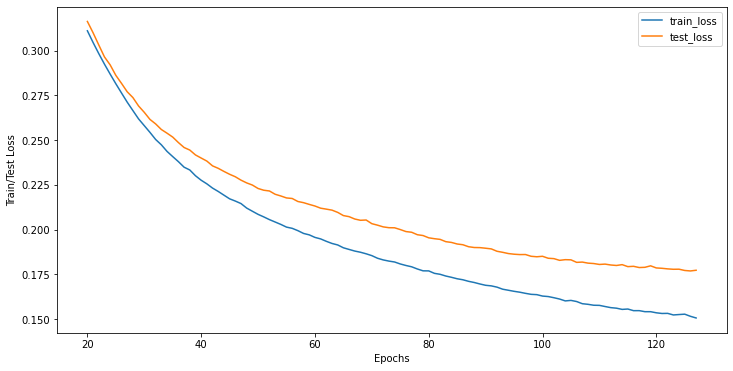

In [34]:
aa=20
plt.figure(figsize=(12, 6))
sb.lineplot(x='epoch',y='loss',data=loss_df[aa:],)
sb.lineplot(x='epoch',y='val_loss',data=loss_df[aa:],)



plt.xlabel("Epochs")
plt.ylabel("Train/Test Loss")
plt.legend(['train_loss','test_loss'])
plt.show()

In [35]:
nn3_wen.save("C:/Users/shakt/Desktop/FeCoNi-db_MPR_NN-3lay_Wen")

INFO:tensorflow:Assets written to: C:/Users/shakt/Desktop/FeCoNi-db_MPR_NN-3lay_Wen\assets


##### Load trained model

In [36]:
nn3_wen = keras.models.load_model("C:/Users/shakt/Desktop/FeCoNi-db_MPR_NN-3lay_Wen")
nn3_wen.summary()

Model: "property_prediction_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 38)]              0         
                                                                 
 dense (Dense)               (None, 128)               4992      
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dense_2 (Dense)             (None, 32)                2080      
                                                                 
 dense_3 (Dense)             (None, 7)                 231       
                                                                 
Total params: 15,559
Trainable params: 15,559
Non-trainable params: 0
_________________________________________________________________


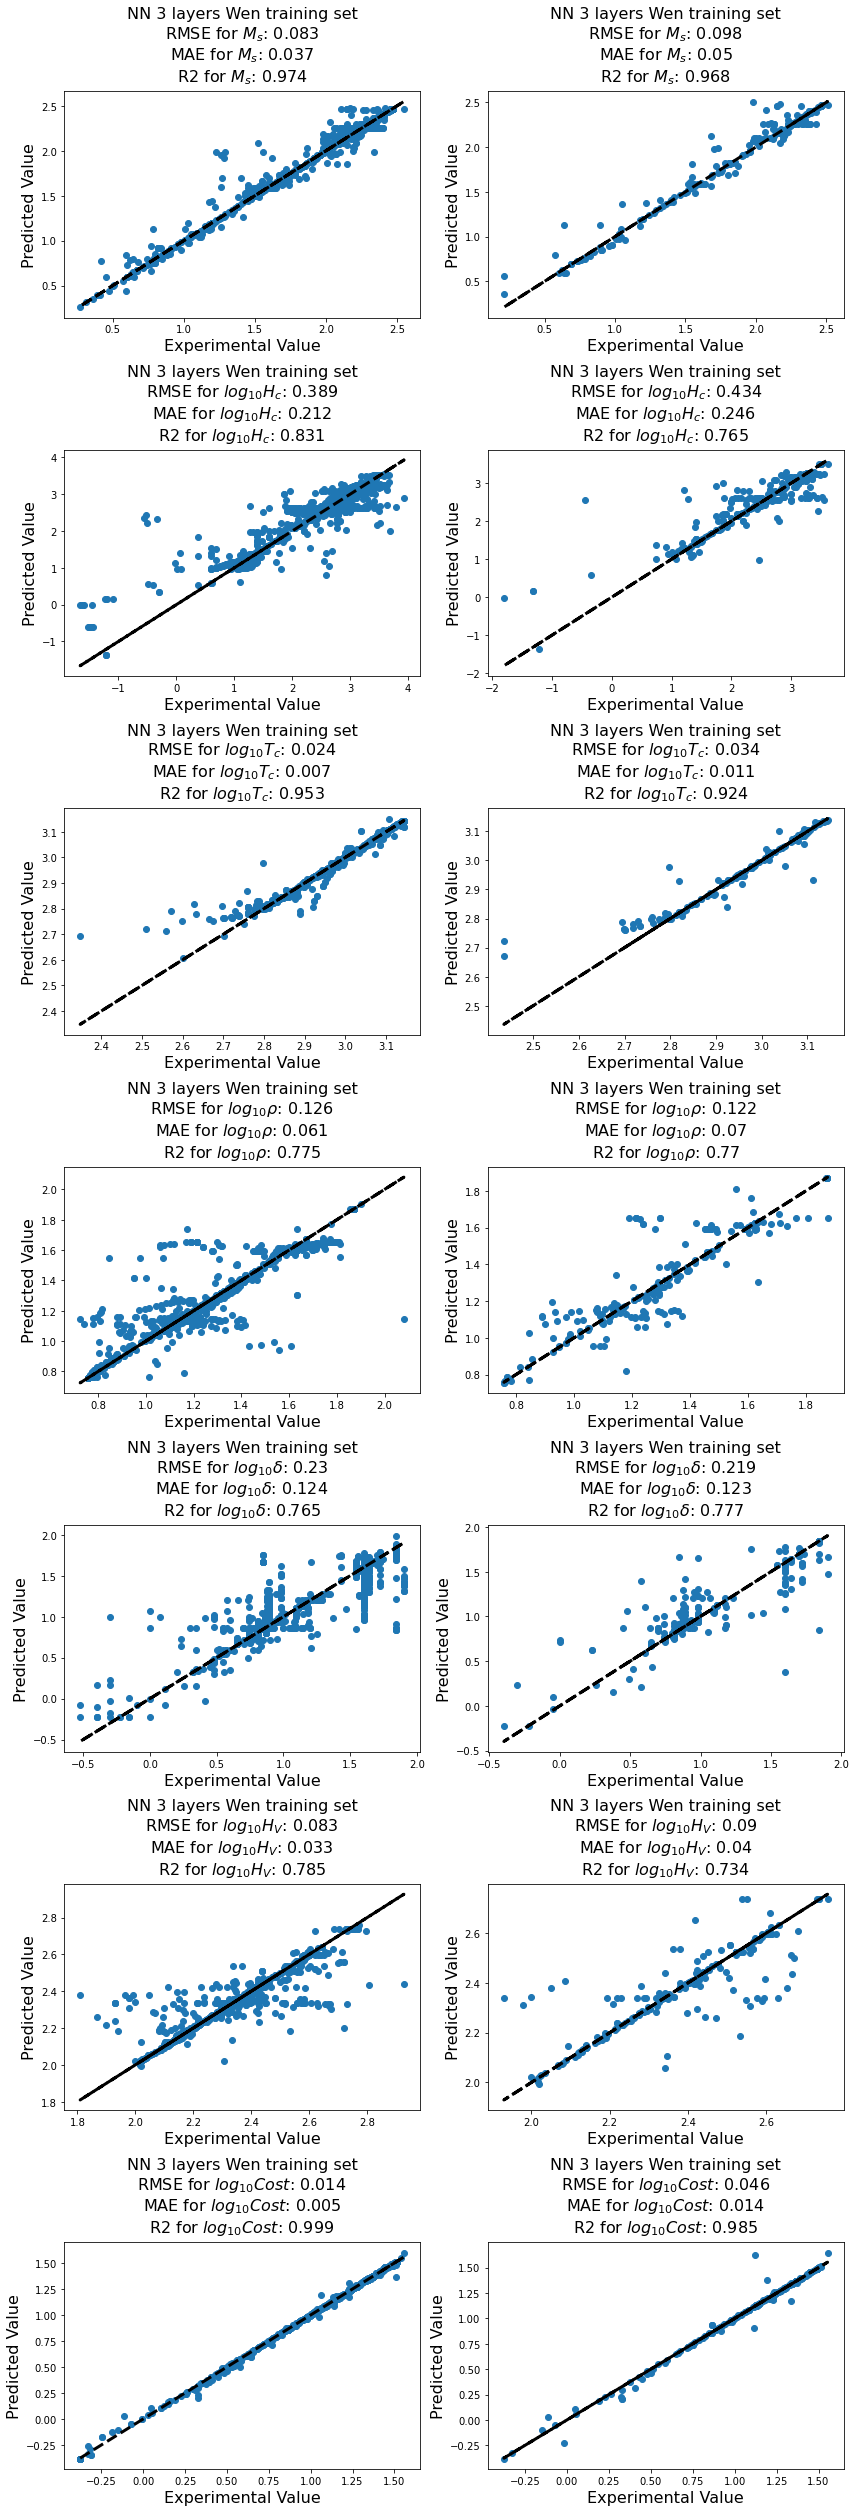

In [145]:
# Use the trained Keras model to predict on the training and test sets
y_pred_train=nn3_wen.predict(X_train)
y_pred_test=nn3_wen.predict(X_test)

# Plot the training results
rmse, mae, R2 = plot('NN 3 layers Wen', y_train, y_pred_train, y_test, y_pred_test)

rmse_scores['NN 3 layers Wen'] = rmse
mae_scores['NN 3 layers Wen'] = mae
R2_scores['NN 3 layers Wen'] = R2

##### Training the 4 layer model for the first time

In [38]:
def model1():
    K.clear_session()
    x = Input(shape=(input_dim,))
    
    # building network
    hd0 = Dense(256, activation='relu')(x)
    hd1 = Dense(128, activation='relu')(hd0)
    hd2 = Dense(64, activation='relu')(hd1)
    hd3 = Dense(32, activation='relu')(hd2)
    output = Dense(output_dim, activation='linear')(hd3)
    
    regression = Model(x,output, name='property_prediction_model')
    
    return regression

In [65]:
nn4_wen = model1()
nn4_wen.summary()

Model: "property_prediction_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 38)]              0         
                                                                 
 dense (Dense)               (None, 256)               9984      
                                                                 
 dense_1 (Dense)             (None, 128)               32896     
                                                                 
 dense_2 (Dense)             (None, 64)                8256      
                                                                 
 dense_3 (Dense)             (None, 32)                2080      
                                                                 
 dense_4 (Dense)             (None, 7)                 231       
                                                                 
Total params: 53,447
Trainable params: 53

In [66]:
# training
nn4_wen.compile(optimizer=Adam(lr=1e-4), loss='mae')
nn4_wen.fit(X_train,y_train,batch_size=32,shuffle=True, callbacks=[CSV,reduce_lr],epochs=128,validation_split=0.0,
            validation_data=(X_test,y_test),initial_epoch=0)

Epoch 1/128


c:\Users\shakt\anaconda3\envs\tensorflow-gpu\lib\site-packages\keras\optimizer_v2\adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


31/31 [==============================] - 1s 8ms/step - loss: 0.7403 - val_loss: 0.6799 - lr: 2.0000e-04
Epoch 2/128
31/31 [==============================] - 0s 5ms/step - loss: 0.6259 - val_loss: 0.5503 - lr: 2.0000e-04
Epoch 3/128
31/31 [==============================] - 0s 5ms/step - loss: 0.4956 - val_loss: 0.4282 - lr: 2.0000e-04
Epoch 4/128
31/31 [==============================] - 0s 4ms/step - loss: 0.3958 - val_loss: 0.3543 - lr: 2.0000e-04
Epoch 5/128
31/31 [==============================] - 0s 4ms/step - loss: 0.3385 - val_loss: 0.3211 - lr: 2.0000e-04
Epoch 6/128
31/31 [==============================] - 0s 4ms/step - loss: 0.3057 - val_loss: 0.3012 - lr: 2.0000e-04
Epoch 7/128
31/31 [==============================] - 0s 4ms/step - loss: 0.2820 - val_loss: 0.2836 - lr: 2.0000e-04
Epoch 8/128
31/31 [==============================] - 0s 4ms/step - loss: 0.2629 - val_loss: 0.2681 - lr: 2.0000e-04
Epoch 9/128
31/31 [==============================] - 0s 4ms/step - loss: 0.2464 - va

In [67]:
loss_df = pd.read_csv('temp_files/training_log.csv')
loss_df

,epoch,loss,val_loss
0,0,0.740298,0.679911
1,1,0.625867,0.550331
2,2,0.495630,0.428229
3,3,0.395756,0.354269
4,4,0.338492,0.321062
...,...,...,...
123,123,0.118828,0.154757
124,124,0.118686,0.154793
125,125,0.118283,0.153780
126,126,0.118157,0.154306


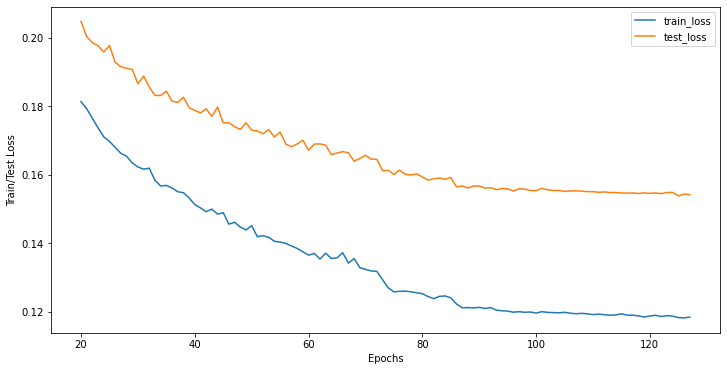

In [68]:
aa=20
plt.figure(figsize=(12, 6))
sb.lineplot(x='epoch',y='loss',data=loss_df[aa:],)
sb.lineplot(x='epoch',y='val_loss',data=loss_df[aa:],)



plt.xlabel("Epochs")
plt.ylabel("Train/Test Loss")
plt.legend(['train_loss','test_loss'])
plt.show()

In [69]:
nn4_wen.save("C:/Users/shakt/Desktop/FeCoNi-db_MPR_NN-4lay")

INFO:tensorflow:Assets written to: C:/Users/shakt/Desktop/FeCoNi-db_MPR_NN-4lay\assets


##### Load trained model

In [70]:
nn4_wen = keras.models.load_model("C:/Users/shakt/Desktop/FeCoNi-db_MPR_NN-4lay")
nn4_wen.summary()

Model: "property_prediction_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 38)]              0         
                                                                 
 dense (Dense)               (None, 256)               9984      
                                                                 
 dense_1 (Dense)             (None, 128)               32896     
                                                                 
 dense_2 (Dense)             (None, 64)                8256      
                                                                 
 dense_3 (Dense)             (None, 32)                2080      
                                                                 
 dense_4 (Dense)             (None, 7)                 231       
                                                                 
Total params: 53,447
Trainable params: 53

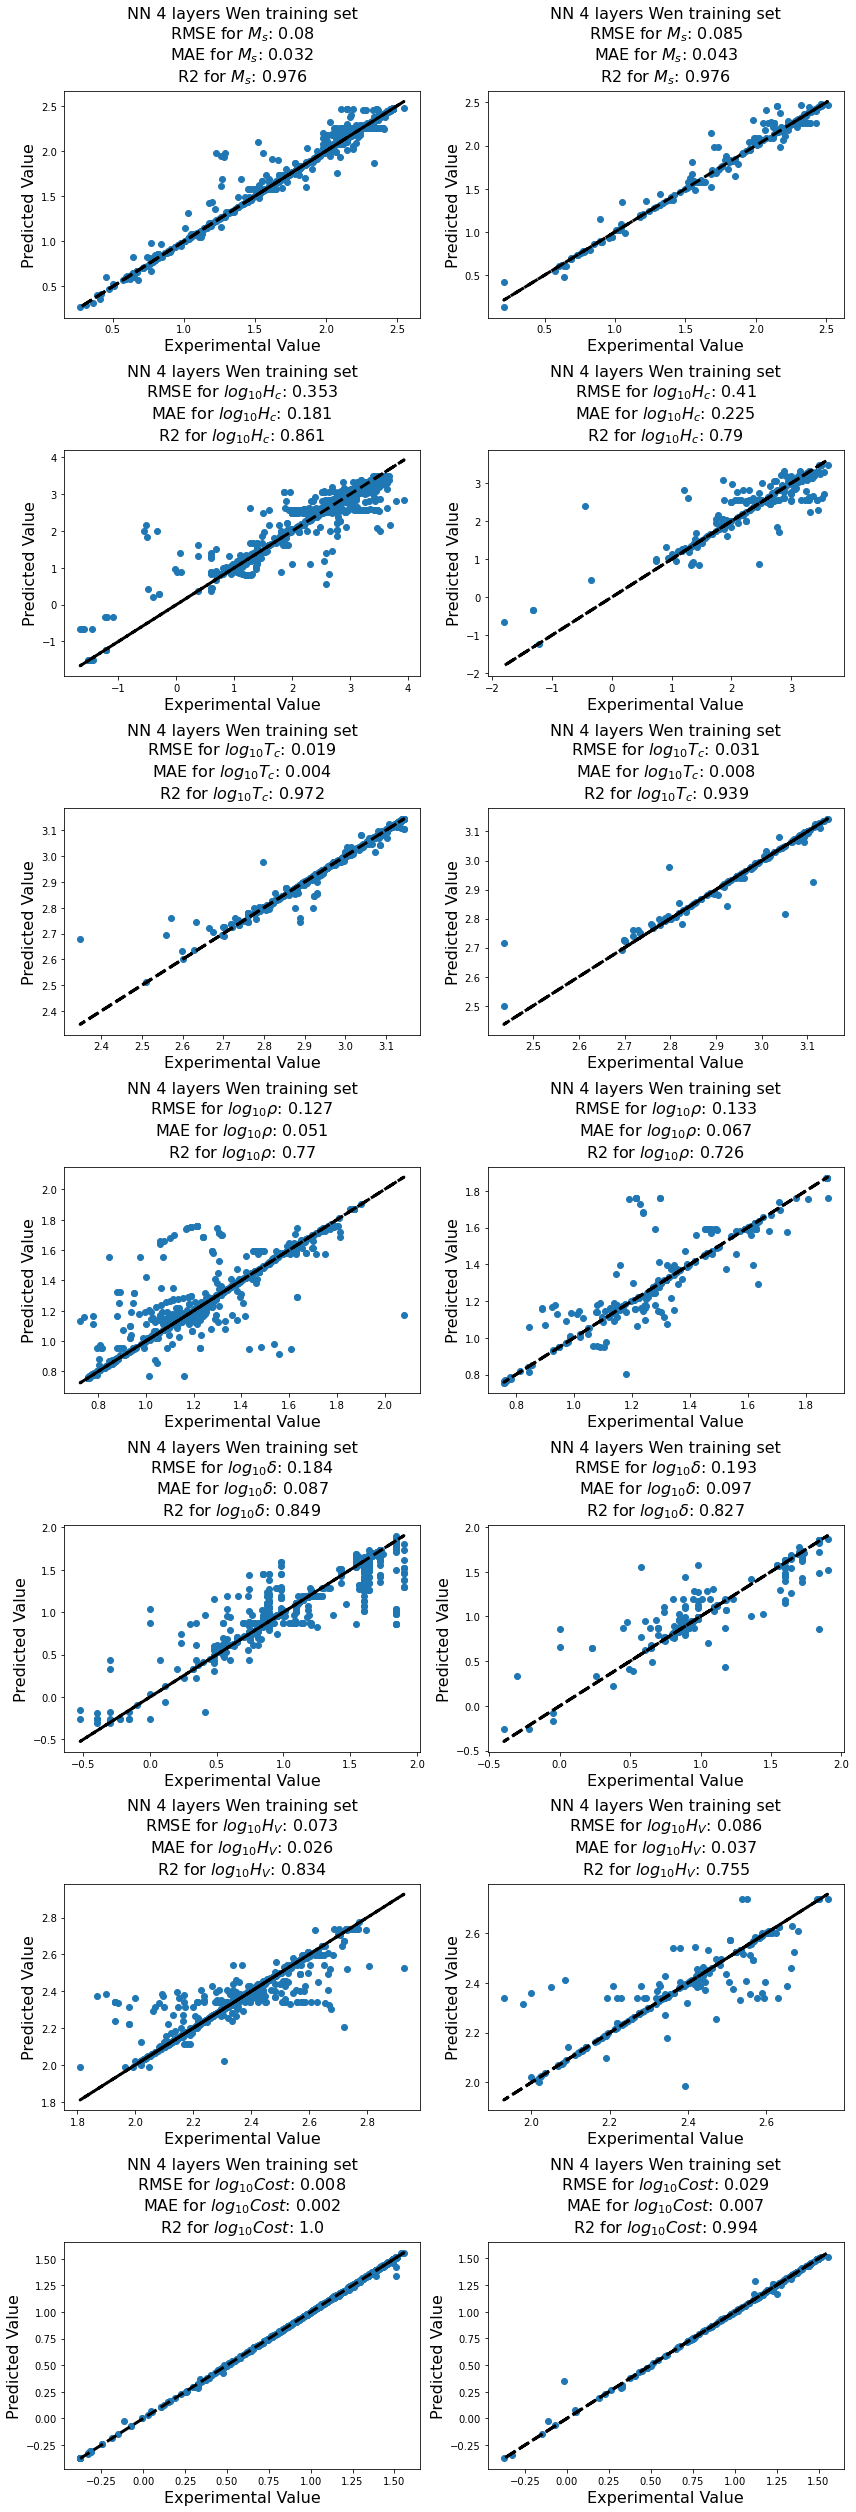

In [146]:
# Use the trained Keras model to predict on the training and test sets
y_pred_train=nn4_wen.predict(X_train)
y_pred_test=nn4_wen.predict(X_test)

# Plot the training results
rmse, mae, R2 = plot('NN 4 layers Wen', y_train, y_pred_train, y_test, y_pred_test)

rmse_scores['NN 4 layers Wen'] = rmse
mae_scores['NN 4 layers Wen'] = mae
R2_scores['NN 4 layers Wen'] = R2

### Deep Neural Network Regressors

##### Training the same DNN architecture (11 layers, 356 units) with Wen alloy features

In [122]:
# Using the hyperparameters optimized for multi-property regression without Wen alloy features in variables
num_dense_layers = 11
units = 356
activation = 'tanh'
learning_rate = 9.224291893551917e-05
optimizer = 'Adam'
batch_size = 27
epochs = 100

In [123]:
# function to develop NN architecture with same number of units in all hidden layers
def build_and_compile_model(num_dense_layers,units,activation,lr,optimizer):
    model = Sequential()
    model.add(InputLayer(input_shape=(X_train.shape[1],))) #Input Layer with training feature data shape
    model.add(BatchNormalization())
    for i in range(num_dense_layers):
        name = 'layer_dense_{0}'.format(i+1) #name of hidden layer
        model.add(Dense(units,activation=activation,name=name)) #add hidden layer(s)
        model.add(BatchNormalization())
    model.add(Dense(y_train.shape[1], activation='linear')) #final layer before output layer
    if optimizer == 'Adam':
        opt = keras.optimizers.Adam(learning_rate=lr)
    if optimizer == 'SGD':
        opt = keras.optimizers.SGD(learning_rate=lr)
    if optimizer == 'RMSprop':
        opt = keras.optimizers.RMSprop(learning_rate=lr)
    model.compile(loss='mean_absolute_error', optimizer=opt, metrics=['mean_squared_error'])
    return model

In [124]:
# Create the neural network with these hyper-parameters.
model1 = build_and_compile_model(num_dense_layers, units, activation, learning_rate, optimizer)
    
# Train the model.
history = model1.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_split=0.2, verbose=0)

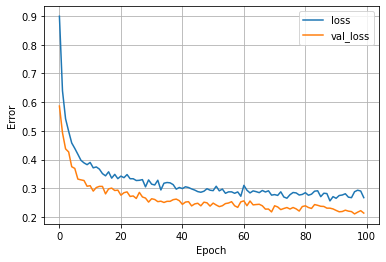

In [125]:
#function to plot the training and validation history of the NN
def plot_loss(history):
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.xlabel('Epoch')
    plt.ylabel('Error')
    plt.legend()
    plt.grid(True)

plot_loss(history)

In [126]:
model1.save("C:/Users/shakt/Desktop/FeCoNi-db_MPR_DNN-rect_wen")

INFO:tensorflow:Assets written to: C:/Users/shakt/Desktop/FeCoNi-db_MPR_DNN-rect_wen\assets


##### Load the trained model

In [127]:
model1 = keras.models.load_model("C:/Users/shakt/Desktop/FeCoNi-db_MPR_DNN-rect_wen")
model1.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization_32 (Bat  (None, 38)               152       
 chNormalization)                                                
                                                                 
 layer_dense_1 (Dense)       (None, 356)               13884     
                                                                 
 batch_normalization_33 (Bat  (None, 356)              1424      
 chNormalization)                                                
                                                                 
 layer_dense_2 (Dense)       (None, 356)               127092    
                                                                 
 batch_normalization_34 (Bat  (None, 356)              1424      
 chNormalization)                                                
                                                      

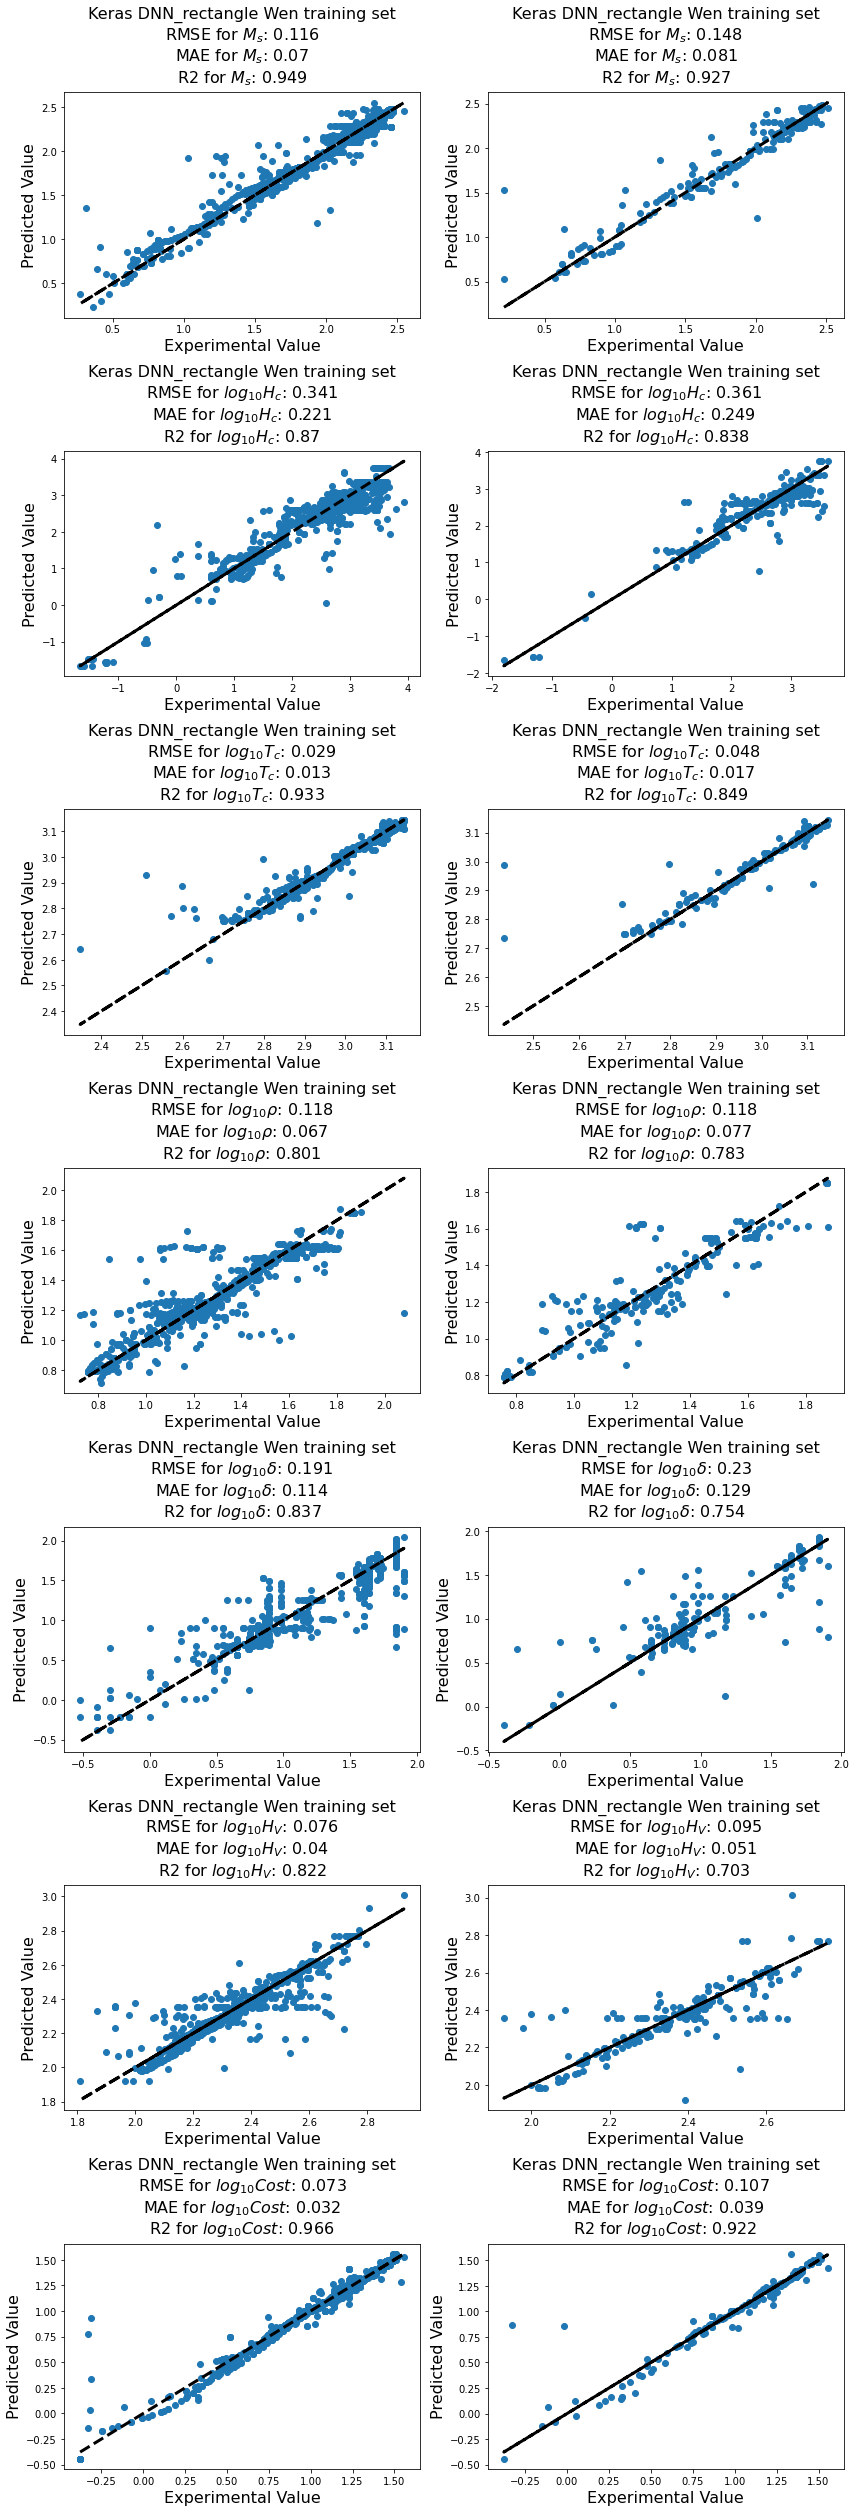

In [147]:
# Use the trained Keras model to predict on the training and test sets
y_pred_train=model1.predict(X_train)
y_pred_test=model1.predict(X_test)

# Plot the training results
rmse, mae, R2 = plot('Keras DNN_rectangle Wen', y_train, y_pred_train, y_test, y_pred_test)

rmse_scores['Keras DNN_rectangle Wen'] = rmse
mae_scores['Keras DNN_rectangle Wen'] = mae
R2_scores['Keras DNN_rectangle Wen'] = R2

##### Training the same DNN  architecture (11 layers, different number of units) with Wen alloy features

In [129]:
# Storing the hyperparameters in variables to develop the NN architecture
units_1 = 1285
units_2 = 1038
units_3 = 362
units_4 = 1007
units_5 = 403
units_6 = 233
units_7 = 562
units_8 = 1216
units_9 = 805
units_10 = 406
units_11 = 768
activation = 'tanh'
learning_rate = 0.00012948654826718263
optimizer = 'Adam'
batch_size = 74
epochs = 100

In [130]:
# function to develop NN architecture with different number of units in different hidden layers
def compile_model(units_1,units_2,units_3,units_4,units_5,units_6,units_7,units_8,units_9,units_10,units_11,activation,lr,optimizer):
    model = keras.Sequential()
    model.add(InputLayer(input_shape=(X_train.shape[1],))) #Input Layer with training feature data shape
    model.add(BatchNormalization())
    name = 'layer_dense_1'#name of hidden layer
    model.add(Dense(units_1, activation=activation, name=name)) #add hidden layer(s)
    model.add(BatchNormalization())
    name = 'layer_dense_2'#name of hidden layer
    model.add(Dense(units_2, activation=activation, name=name)) #add hidden layer(s)
    model.add(BatchNormalization())
    name = 'layer_dense_3'#name of hidden layer
    model.add(Dense(units_3, activation=activation, name=name)) #add hidden layer(s)
    model.add(BatchNormalization())
    name = 'layer_dense_4'#name of hidden layer
    model.add(Dense(units_4, activation=activation, name=name)) #add hidden layer(s)
    model.add(BatchNormalization())
    name = 'layer_dense_5'#name of hidden layer
    model.add(Dense(units_5, activation=activation, name=name)) #add hidden layer(s)
    model.add(BatchNormalization())
    name = 'layer_dense_6'#name of hidden layer
    model.add(Dense(units_6, activation=activation, name=name)) #add hidden layer(s)
    model.add(BatchNormalization())
    name = 'layer_dense_7'#name of hidden layer
    model.add(Dense(units_7, activation=activation, name=name)) #add hidden layer(s)
    model.add(BatchNormalization())
    name = 'layer_dense_8'#name of hidden layer
    model.add(Dense(units_8, activation=activation, name=name)) #add hidden layer(s)
    model.add(BatchNormalization())
    name = 'layer_dense_9'#name of hidden layer
    model.add(Dense(units_9, activation=activation, name=name)) #add hidden layer(s)
    model.add(BatchNormalization())
    name = 'layer_dense_10'#name of hidden layer
    model.add(Dense(units_10, activation=activation, name=name)) #add hidden layer(s)
    model.add(BatchNormalization())
    name = 'layer_dense_11'#name of hidden layer
    model.add(Dense(units_11, activation=activation, name=name)) #add hidden layer(s)
    model.add(BatchNormalization())
    model.add(Dense(y_train.shape[1], activation='linear')) #final layer before output layer
    if optimizer == 'Adam':
        opt = keras.optimizers.Adam(learning_rate=lr)
    if optimizer == 'SGD':
        opt = keras.optimizers.SGD(learning_rate=lr)
    if optimizer == 'RMSprop':
        opt = keras.optimizers.RMSprop(learning_rate=lr)
    model.compile(loss='mean_absolute_error', optimizer=opt, metrics=['mean_squared_error'])
    return model

In [131]:
# Create the neural network with these hyper-parameters.
model2 = compile_model(units_1,units_2,units_3,units_4,units_5,units_6,units_7,units_8,units_9,units_10,units_11,activation,learning_rate,optimizer)
    
# Train the model.
history = model2.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_split=0.2, verbose=0)

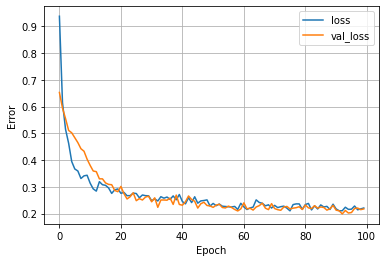

In [132]:
plot_loss(history)

In [133]:
model2.save("C:/Users/shakt/Desktop/FeCoNi-db_MPR_DNN-rand_wen")

INFO:tensorflow:Assets written to: C:/Users/shakt/Desktop/FeCoNi-db_MPR_DNN-rand_wen\assets


##### Load the trained model

In [134]:
model2 = keras.models.load_model("C:/Users/shakt/Desktop/FeCoNi-db_MPR_DNN-rand_wen")
model2.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization_44 (Bat  (None, 38)               152       
 chNormalization)                                                
                                                                 
 layer_dense_1 (Dense)       (None, 1285)              50115     
                                                                 
 batch_normalization_45 (Bat  (None, 1285)             5140      
 chNormalization)                                                
                                                                 
 layer_dense_2 (Dense)       (None, 1038)              1334868   
                                                                 
 batch_normalization_46 (Bat  (None, 1038)             4152      
 chNormalization)                                                
                                                      

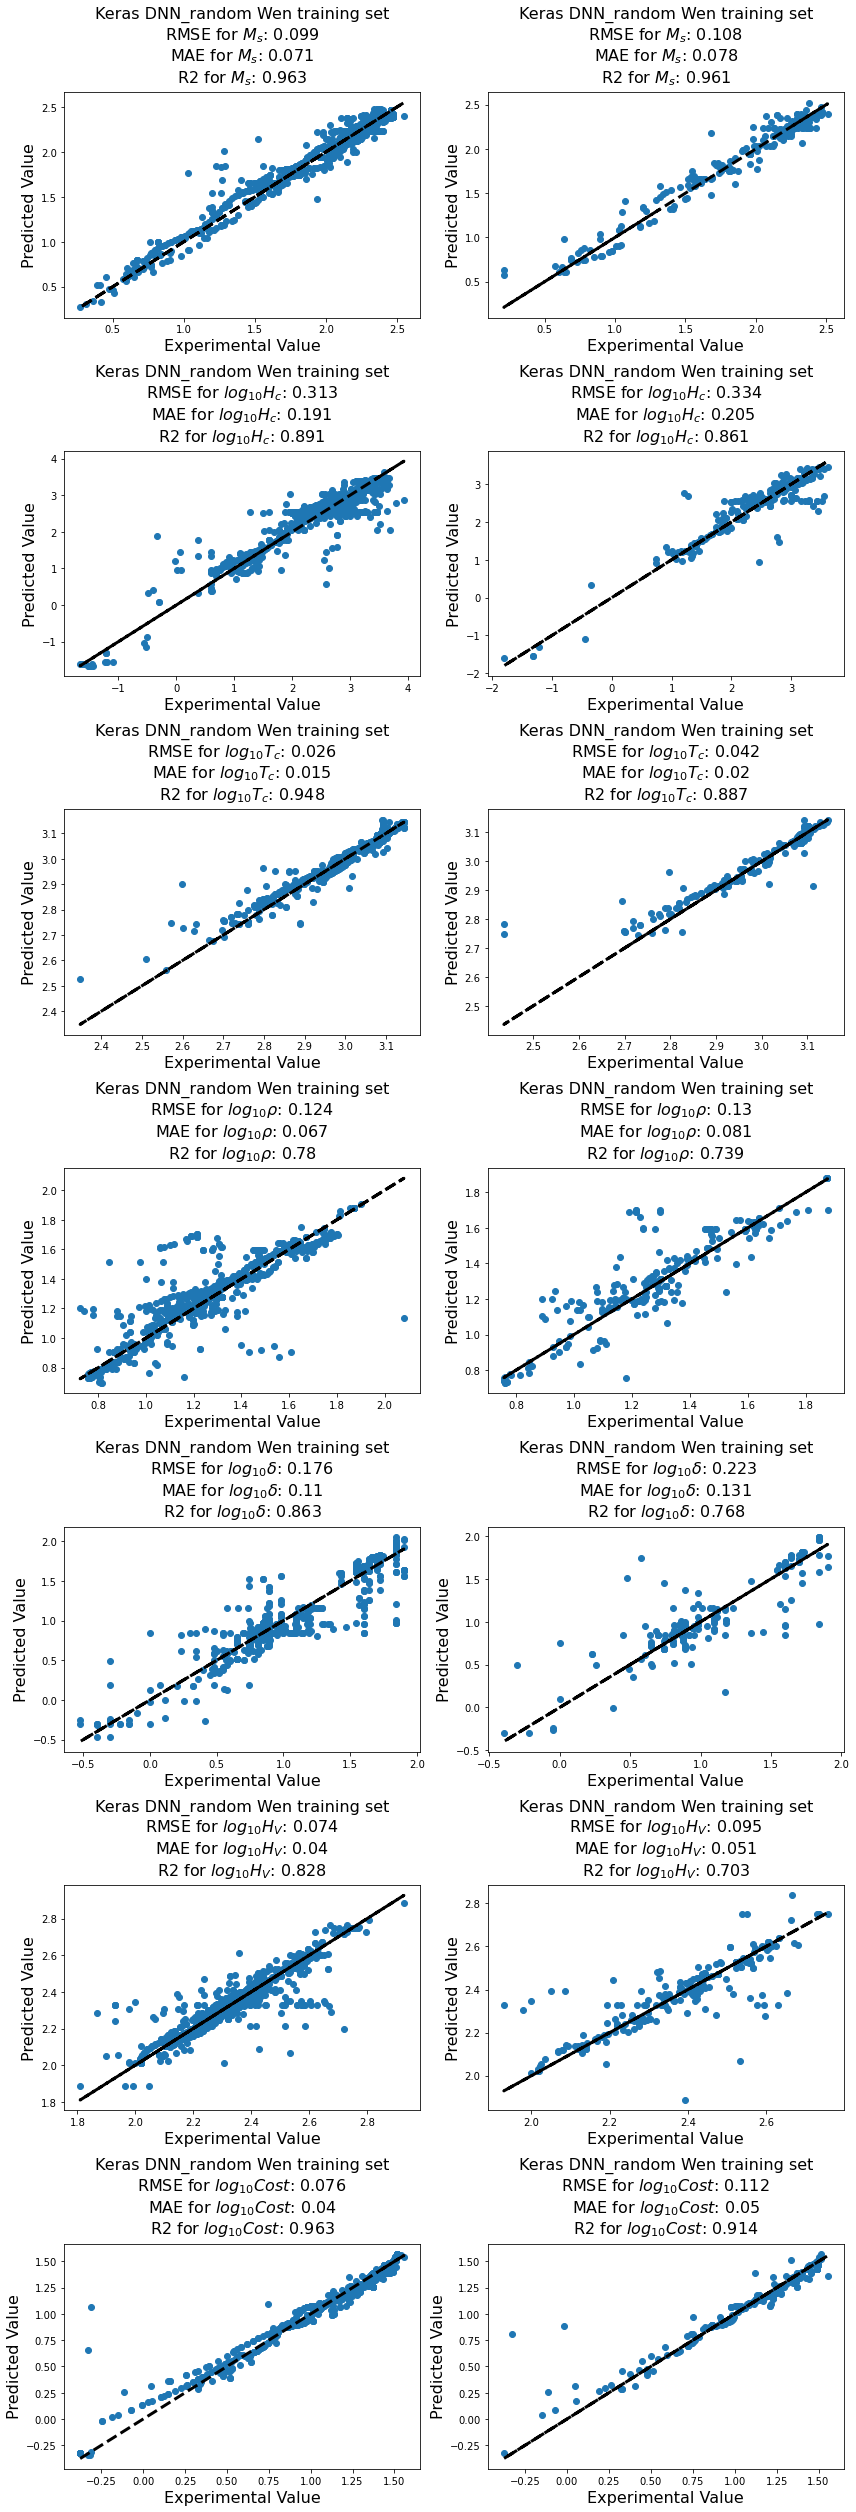

In [148]:
# Use the trained Keras model to predict on the training and test sets
y_pred_train=model2.predict(X_train)
y_pred_test=model2.predict(X_test)

# Plot the training results
rmse, mae, R2 = plot('Keras DNN_random Wen', y_train, y_pred_train, y_test, y_pred_test)

rmse_scores['Keras DNN_random Wen'] = rmse
mae_scores['Keras DNN_random Wen'] = mae
R2_scores['Keras DNN_random Wen'] = R2

In [152]:
# Creating dataframe of the metrics of the 4 regressors used 
rmse = pd.DataFrame(list(rmse_scores.items()),columns = ['Regressor','RMSE'])
mae = pd.DataFrame(list(mae_scores.items()),columns = ['Regressor','MAE'])
r2 = pd.DataFrame(list(R2_scores.items()),columns = ['Regressor','R2'])
scores_df = pd.concat([rmse,mae.iloc[:,1],r2.iloc[:,1]],axis=1)
scores_df

,Regressor,RMSE,MAE,R2
0,Random Forest Wen,"{'Ms': [0.07843233672019626], 'logHc': [0.2999...","{'Ms': [0.043051009094598684], 'logHc': [0.170...","{'Ms': [0.9793727182637081], 'logHc': [0.88783..."
1,Extra Trees Wen,"{'Ms': [0.08019907763259884], 'logHc': [0.3150...","{'Ms': [0.03994544340764996], 'logHc': [0.1603...","{'Ms': [0.9784329651901256], 'logHc': [0.87621..."
2,NN 3 layers Wen,"{'Ms': [0.09804550518472094], 'logHc': [0.4343...","{'Ms': [0.049683788908414614], 'logHc': [0.245...","{'Ms': [0.9677665293518448], 'logHc': [0.76479..."
3,NN 4 layers Wen,"{'Ms': [0.08493367483019103], 'logHc': [0.4101...","{'Ms': [0.04319250734630697], 'logHc': [0.2253...","{'Ms': [0.9758113560117898], 'logHc': [0.79025..."
4,Keras DNN_rectangle Wen,"{'Ms': [0.14790991736034667], 'logHc': [0.3608...","{'Ms': [0.08075182936605345], 'logHc': [0.2487...","{'Ms': [0.926642202912169], 'logHc': [0.837614..."
5,Keras DNN_random Wen,"{'Ms': [0.10781752835817601], 'logHc': [0.3339...","{'Ms': [0.07849010119950477], 'logHc': [0.2050...","{'Ms': [0.9610210231080621], 'logHc': [0.86099..."


In [153]:
# Exporting the performance metric results
scores_df.to_excel('Multi-property models results Wen features.xlsx')

It can be observed that the extra trees regressor showed the minimum mean absolute errors for the properties compared to other regression models. Moreover, Neural Network with 4 layers showed comparatively good performance too.